In [1]:
using Random
using Statistics
using Plots
using Distributions
using DataFrames
using GLM
using StatsBase
using CSV

#　AR(p)モデル(ホワイトノイズ, 弱定常）

$$y_t = \nu + \sum_{i = 1}^p \phi_i y_{t-i} + \varepsilon_t, \quad t \geq p, \: (y_0, y_1, \dots, y_{p-1}) = (y^*_0, \cdots, y^*_{p-1})$$

ただし $$\: E(\varepsilon_t) = 0, \: Var(\varepsilon_t) = \sigma^2, E[y_{t-1}\varepsilon_t] = 0, \quad 1-\sum_{i - 1}^p \phi_i z^i = 0 \:\text{のすべての解が} \: |z| > 1 \: \text{を満たす とする} $$

## 1. 理想的なデータセットを生成して分析

### データセット生成

In [2]:
#設定

p = 3 #とする
T = 2000
nu = 1
sigma = 1
Dist = Normal(0, sigma^2)
Random.seed!(1234)
Phi = [-.1 -.3 1.2] #左から3次、2次、1次のラグ
y0  = 4.5
y1 = 4.5
y2 = 4.5


#誤差項の生成
e = rand(Dist, T)

2000-element Vector{Float64}:
  0.9706563288552144
 -0.9792184115351997
  0.9018608835940937
 -0.03280312924463938
 -0.6007922233555612
 -1.445177115286233
  2.7074239417157804
  1.5244478634355956
  0.759804020007466
 -0.8814369061964817
  0.7059931337826102
  1.0915552820534098
  0.871497852880908
  ⋮
  0.5472257934521602
  0.08734202311833826
  0.6456946535904136
  0.8986349391013186
  0.09896774839837082
 -0.7230746259696292
  0.8050128049089171
 -0.95259304312527
  0.6663703372119086
 -0.03981246583483689
  0.28828236124637935
 -3.5582321541854967

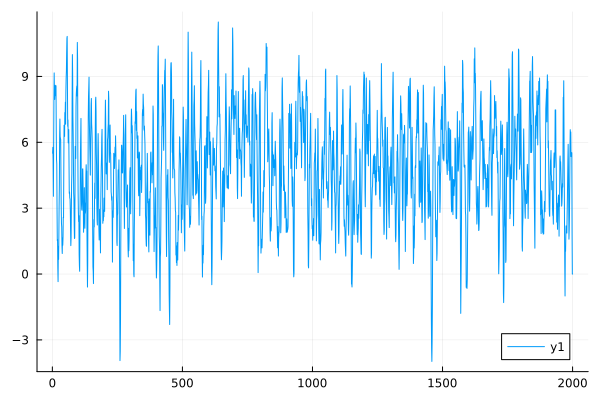

In [3]:
#データセットの生成
y = zeros(T + p, 1)
y[1] = y0
y[2] = y1
y[3] = y2

for t in p:T
    temp = Phi * y[t-2:t]
    y[t+1] = nu + temp[1] + e[t]
end
y = y[p+1:T+p]
plot(y)

### パラメータ推定

In [4]:
#AIC, BICによるラグ次数推定
function Lagorder(y, p_max)
    Mat_IC = zeros(p_max, 3)
    T = size(y, 1)
    
    for p in 1:p_max #pの探索領域最大値
        y_dep = y[1+p:T]
        y_exp = ones(T-p, p+1)
        for i in 1:p
            y_exp[:,i+1] = y[i:T-p+i-1]
        end
        model_temp = lm(y_exp, y_dep)

        Mat_IC[p, :] = [aic(model_temp), aicc(model_temp), bic(model_temp)]
    end
    Mat_IC = DataFrame(Mat_IC, [:AIC, :AIC_adj, :BIC])
    println(Mat_IC) #情報基準を表示

    #各基準ごとに最小にするラグ次数を返す
    min_v = minimum.(eachcol(Mat_IC[!, :]))'
    p_sel = ones(1,3)
    for i in 1:3
        p_sel[1, i] = findall(x -> x == min_v[i], Mat_IC[:,i])[1]
    end
    return p_sel
end

Lagorder (generic function with 1 method)

In [5]:
Lagorder(y, 10)

10×3 DataFrame
 Row │ AIC      AIC_adj  BIC     
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │ 6232.62  6232.63  6249.42
   2 │ 5787.7   5787.72  5810.1
   3 │ 5763.79  5763.83  5791.79
   4 │ 5761.81  5761.85  5795.41
   5 │ 5753.04  5753.1   5792.23
   6 │ 5750.8   5750.88  5795.59
   7 │ 5750.15  5750.24  5800.52
   8 │ 5749.22  5749.33  5805.19
   9 │ 5748.66  5748.8   5810.22
  10 │ 5746.07  5746.23  5813.22


1×3 Matrix{Float64}:
 10.0  10.0  3.0

In [6]:
p_sel = 3

3

In [7]:
#phiのOLS推定とインパルス応答関数描画
function AR_OLS(y, p_sel)
    T = size(y,1)
    y_dep = y[1+p_sel:T]
    y_exp = ones(T- p_sel, p_sel+ 1)
    for i in 1:p_sel
        y_exp[:,i+1] = y[i:T-p_sel+i-1]
    end
    model = lm(y_exp, y_dep)
    println(model)
    phis = coef(model)[2:p_sel+1]

    plotT = 30 #描画最大期
    std_est =  sqrt(deviance(model)/(T-p_sel-1))
    print("Standad error of error term: ",std_est) #誤差項の(不偏)標準偏差を求めてインパルスの基準にする
    
    Resp = zeros(plotT+p_sel)
    Resp[p_sel] = std_est
    for t in 1:30
       Resp[t+p_sel] = transpose(Resp[t:t+p_sel-1]) * phis
    end
    deleteat!(Resp, 1:p_sel-1)
    display(plot(Resp))

    return phis, std_est
end

AR_OLS (generic function with 1 method)

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
─────────────────────────────────────────────────────────────────
        Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────
x1   0.958528   0.0566435  16.92    <1e-59   0.847442   1.06961
x2  -0.108932   0.0222949  -4.89    <1e-05  -0.152656  -0.0652084
x3  -0.309236   0.03457    -8.95    <1e-18  -0.377034  -0.241439
x4   1.21977    0.0222656  54.78    <1e-99   1.1761     1.26344
─────────────────────────────────────────────────────────────────

Standad error of error term: 1.022163589052948

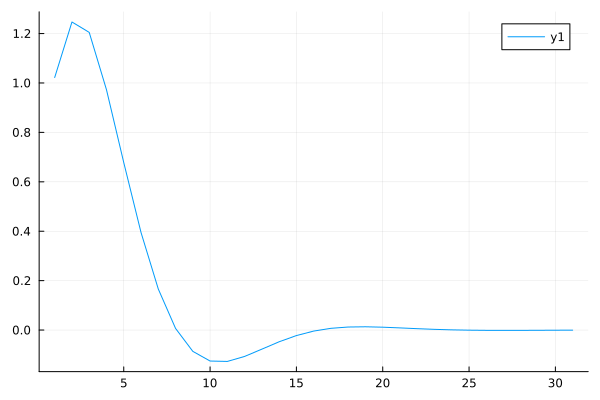

([-0.10893216082246539, -0.3092364611214675, 1.2197697925973638], 1.022163589052948)

In [8]:
phis, std_est = AR_OLS(y, p_sel)

## 2. マクロデータ（GDPギャップ）による実証

In [9]:
Gap = CSV.read("JapanBank_GDPgap.csv", header = true, DataFrame)

Row,Quarterly,Output gap,Capital input gap,Labor input gap,Tankan factor utilization index,Tankan factor utilization index_1
,String7,Float64,Float64,Float64,Float64?,Float64?
1,1983.1Q,-1.47,-1.66,0.19,missing,missing
2,1983.2Q,-1.19,-1.37,0.18,missing,missing
3,1983.3Q,-0.91,-1.12,0.2,missing,missing
4,1983.4Q,-0.5,-0.64,0.14,missing,missing
5,1984.1Q,-0.15,-0.11,-0.05,missing,missing
6,1984.2Q,0.05,-0.11,0.16,missing,missing
7,1984.3Q,0.3,0.04,0.26,missing,missing
8,1984.4Q,0.76,0.49,0.27,missing,missing
9,1985.1Q,0.71,0.53,0.18,missing,missing


In [10]:
y_gap = Gap[:, 2]

167-element Vector{Float64}:
 -1.47
 -1.19
 -0.91
 -0.5
 -0.15
  0.05
  0.3
  0.76
  0.71
  0.58
  0.18
 -0.12
 -0.12
  ⋮
 -1.52
 -1.03
 -0.67
 -0.28
 -0.43
 -0.36
 -0.12
 -0.34
 -0.05
 -0.71
 -0.58
 -0.53

In [11]:
Lagorder(y_gap, 12)

12×3 DataFrame
 Row │ AIC      AIC_adj  BIC     
     │ Float64  Float64  Float64 
─────┼───────────────────────────
   1 │ 310.807  310.955  320.143
   2 │ 282.388  282.638  294.812
   3 │ 282.626  283.005  298.125
   4 │ 283.687  284.225  302.249
   5 │ 284.359  285.086  305.972
   6 │ 285.022  285.969  309.673
   7 │ 285.847  287.047  313.523
   8 │ 286.281  287.768  316.97
   9 │ 287.504  289.312  321.192
  10 │ 288.723  290.889  325.398
  11 │ 289.658  292.221  329.306
  12 │ 290.899  293.899  333.507


1×3 Matrix{Float64}:
 2.0  2.0  2.0

In [12]:
p_sel_gap = 2

2

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
────────────────────────────────────────────────────────────────────
          Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────
x1  -0.00838042   0.0437471  -0.19    0.8483  -0.0947684   0.0780076
x2  -0.403739     0.0716839  -5.63    <1e-07  -0.545295   -0.262184
x3   1.2924       0.0718314  17.99    <1e-39   1.15055     1.43425
────────────────────────────────────────────────────────────────────

Standad error of error term: 0.557428575999256

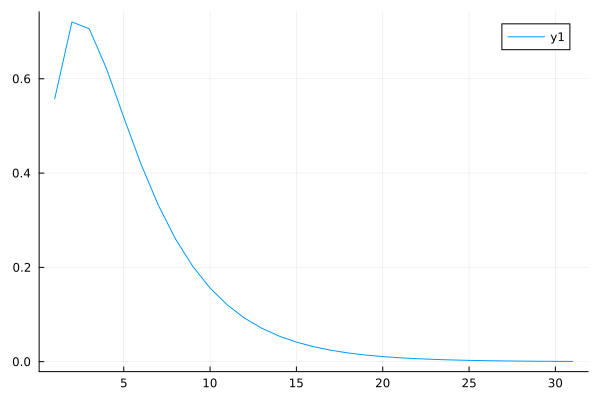

([-0.4037391385439152, 1.2924003636329613], 0.557428575999256)

In [13]:
AR_OLS(y_gap, p_sel_gap)